# Scribe: Realistic Handwriting with TensorFlow

<img src="static/author.png" alt="A project by Sam Greydanus" style="width: 70%;"/>

This model is trained on the IAM handwriting dataset and was inspired by the model described by the famous 2014 Alex Graves [paper](http://arxiv.org/abs/1308.0850). It consists of a three-layer recurrent neural network (LSTM cells) with a Gaussian Mixture Density Network (MDN) cap on top. I have also implemented the attention mechanism from the paper which allows the network to 'focus' on character at a time in a sequence as it draws them.

This iPython notebook (named **sample**) demonstrates how to
1. build the model
2. load saved parameters
3. generate handwriting

## Dependencies

In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import math
import random
import time
import os
import cPickle as pickle

import tensorflow as tf #built with TensorFlow version 1.0

## Define hyperparameters

Note that *tsteps* and *batch_size* are both 1 when we're sampling

In [2]:
# in the real project class, we use argparse (https://docs.python.org/3/library/argparse.html)
class FakeArgParse():
    def __init__(self):
        pass
args = FakeArgParse()

#general model params
args.train = False
args.rnn_size = 100 #400 hidden units
args.tsteps = 256 if args.train else 1
args.batch_size = 32 if args.train else 1
args.nmixtures = 8 # number of Gaussian mixtures in MDN

#window params
args.kmixtures = 1 # number of Gaussian mixtures in attention mechanism (for soft convolution window)
args.alphabet = ' abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ' #later we'll add an <UNK> slot for unknown chars
args.tsteps_per_ascii = 25 # an approximate estimate

#book-keeping
args.save_path = './saved/model.ckpt'
args.data_dir = './data'
args.log_dir = './logs/'
args.text = 'call me ishmael some years ago'
args.style = -1 # don't use a custom style
args.bias = 1.0
args.eos_prob = 0.4 # threshold probability for ending a stroke

## Model overview

Let's start with an overview. The backbone of the model is three LSTM cells (green). There is a a custom attention mechanism (yellow) which digests a one-hot encoding of the sentence we want the model to write. The Mixture Density Network (red) on top choses apropriate Gaussian distributions from which to sample the next pen point, adding some natural randomness to the model.
<img src="static/model_rolled.png" alt="Handwriting model structure" style="width: 40%;"/>
As we build the model, we'll start with the inputs and work our way upwards through the computational graph. The code is optimized for minibatch training but in this case we already set the `args.batch_size` to 1.

In [3]:
# in real life the model is a class. I used this hack to make the iPython notebook more readable
class FakeModel():
    def __init__(self):
        pass
model = FakeModel()

## Initialize LSTMs and build LSTM 1

In [4]:

model.char_vec_len = len(args.alphabet) + 1 #plus one for <UNK> token
model.ascii_steps = len(args.text)

model.graves_initializer = tf.truncated_normal_initializer(mean=0., stddev=.075, seed=None, dtype=tf.float32)
model.window_b_initializer = tf.truncated_normal_initializer(mean=-3.0, stddev=.25, seed=None, dtype=tf.float32)

# ----- build the basic recurrent network architecture
cell_func = tf.contrib.rnn.LSTMCell # could be GRUCell or RNNCell
model.cell0 = cell_func(args.rnn_size, state_is_tuple=True, initializer=model.graves_initializer)
model.cell1 = cell_func(args.rnn_size, state_is_tuple=True, initializer=model.graves_initializer)
model.cell2 = cell_func(args.rnn_size, state_is_tuple=True, initializer=model.graves_initializer)

model.input_data = tf.placeholder(dtype=tf.float32, shape=[None, args.tsteps, 3])
model.target_data = tf.placeholder(dtype=tf.float32, shape=[None, args.tsteps, 3])
model.istate_cell0 = model.cell0.zero_state(batch_size=args.batch_size, dtype=tf.float32)
model.istate_cell1 = model.cell1.zero_state(batch_size=args.batch_size, dtype=tf.float32)
model.istate_cell2 = model.cell2.zero_state(batch_size=args.batch_size, dtype=tf.float32)

#slice the input volume into separate vols for each tstep
inputs = [tf.squeeze(input_, [1]) for input_ in tf.split(model.input_data, args.tsteps, 1)]

#build model.cell0 computational graph
outs_cell0, model.fstate_cell0 = tf.contrib.legacy_seq2seq.rnn_decoder(inputs, model.istate_cell0, \
                                                       model.cell0, loop_function=None, scope='cell0')

In the cell above we use the TensorFlow `seq2seq` [API](https://www.tensorflow.org/versions/r0.10/tutorials/seq2seq/index.html) to create three LSTM cells. Learn about how LSTMs work [here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/). When we unroll the model in time, it will look like this (arrows denote flow of data)
<img src="static/model_unrolled.png" alt="Handwriting model unrolled" style="width: 80%;"/>
We've already built the computational graph for the first LSTM cell. Our next task is to build the attention mechanism

## Build the attention mechanism

The attention mechanism performs a Gaussian convolution over a one-hot encoding of the input text using a mixture of Gaussians. Its final output is a soft window into the one-hot encoding of the character the model thinks it is drawing. When we stack these soft windows vertically over time, we get a heatmap like this:

<img src="static/onehot_window.png" alt="One-hot window" style="width: 50%;"/>

Don't worry about how the mixture of Gaussians works together - we'll go over this in more detail later. For now, focus on building an intuition for how the parameters $\alpha$, $\beta$, and $\kappa$ affect the window's behavior.

These three parameters control the character window $w_t$ according to
$$(\hat \alpha_t,\hat \beta_t, \hat \kappa_t)=W_{h^1 p}h_t^1+b_p$$

Each of these parameters are outputs from a dense layer on top of the first LSTM which we then transform according to:
$$\alpha_t=\exp (\hat \alpha_t) \quad \quad \beta_t=\exp (\hat \beta_t) \quad \quad \kappa_t= \kappa_{t-1} + \exp (\hat \kappa_t)$$

From these parameters we can construct the window as a convolution:
$$w_t=\sum_{u=1}^U \phi(t,u)c_u \quad \quad \phi(t,u)= \sum_{k=1}^K \alpha_t^k \exp \left( -\beta_t^k(\kappa_t^k-u)^2 \right)$$

In [5]:
# ----- build the gaussian character window
def get_window(alpha, beta, kappa, c):
    # phi -> [? x 1 x ascii_steps] and is a tf matrix
    # c -> [? x ascii_steps x alphabet] and is a tf matrix
    ascii_steps = c.get_shape()[1].value #number of items in sequence
    phi = get_phi(ascii_steps, alpha, beta, kappa)
    window = tf.matmul(phi,c)
    window = tf.squeeze(window, [1]) # window ~ [?,alphabet]
    return window, phi

#get phi for all t,u (returns a [1 x tsteps] matrix) that defines the window
def get_phi(ascii_steps, alpha, beta, kappa):
    # alpha, beta, kappa -> [?,kmixtures,1] and each is a tf variable
    u = np.linspace(0,ascii_steps-1,ascii_steps) # weight all the U items in the sequence
    kappa_term = tf.square( tf.subtract(kappa,u))
    exp_term = tf.multiply(-beta,kappa_term)
    phi_k = tf.multiply(alpha, tf.exp(exp_term))
    phi = tf.reduce_sum(phi_k,1, keep_dims=True)
    return phi # phi ~ [?,1,ascii_steps]

def get_window_params(i, out_cell0, kmixtures, prev_kappa, reuse=True):
    hidden = out_cell0.get_shape()[1]
    n_out = 3*kmixtures
    with tf.variable_scope('window',reuse=reuse):
        window_w = tf.get_variable("window_w", [hidden, n_out], initializer=model.graves_initializer)
        window_b = tf.get_variable("window_b", [n_out], initializer=model.window_b_initializer)
    abk_hats = tf.nn.xw_plus_b(out_cell0, window_w, window_b) # abk_hats ~ [?,n_out] = "alpha, beta, kappa hats"
    abk = tf.exp(tf.reshape(abk_hats, [-1, 3*kmixtures,1]))

    alpha, beta, kappa = tf.split(abk, 3, 1) # alpha_hat, etc ~ [?,kmixtures]
    kappa = kappa + prev_kappa
    return alpha, beta, kappa # each ~ [?,kmixtures,1]

Alex Graves gives a really nice intuition for the roles of $\alpha$, $\beta$, and $\kappa$ in his paper:
>"Intuitively, the $\kappa_t$ parameters
control the location of the window, the $\beta_t$ parameters control the width of
the window and the $\alpha_t$ parameters control the importance of the window within
the mixture."

Now that we've defined how the attention mechanism works, we need to loop through each of LSTM 1's outputs states and use them as inputs to the attention mechanism. Then, we simply concatenate the outputs of the attention mechanism to the LSTM's state vector. While we're at it, we concatenate the original pen stroke data for good measure. The modified LSTM 1 state vector looks like this:
<img src="static/modified_lstm1_state.png" alt="Motified LSTM 1 state vector" style="width: 75%;"/>

In [6]:

model.init_kappa = tf.placeholder(dtype=tf.float32, shape=[None, args.kmixtures, 1]) 
model.char_seq = tf.placeholder(dtype=tf.float32, shape=[None, model.ascii_steps, model.char_vec_len])
wavg_prev_kappa = model.init_kappa
prev_window = model.char_seq[:,0,:]

#add gaussian window result
reuse = False
for i in range(len(outs_cell0)):
    [alpha, beta, new_kappa] = get_window_params(i, outs_cell0[i], args.kmixtures, wavg_prev_kappa, reuse=reuse)
    window, phi = get_window(alpha, beta, new_kappa, model.char_seq)
    outs_cell0[i] = tf.concat((outs_cell0[i],window), 1) #concat outputs
    outs_cell0[i] = tf.concat((outs_cell0[i],inputs[i]), 1) #concat input data
#         prev_kappa = new_kappa #tf.ones_like(new_kappa, dtype=tf.float32, name="prev_kappa_ones") #
    wavg_prev_kappa = tf.reduce_mean( new_kappa, reduction_indices=1, keep_dims=True) # mean along kmixtures dimension
    reuse = True
model.window = window #save the last window (for generation)
model.phi = phi #save the last window (for generation)
model.new_kappa = new_kappa #save the last window (for generation)
model.alpha = alpha #save the last window (for generation)
model.wavg_prev_kappa = wavg_prev_kappa

## Build LSTMs 2 and 3

In [7]:

# ----- finish building second recurrent cell
outs_cell1, model.fstate_cell1 = tf.contrib.legacy_seq2seq.rnn_decoder(outs_cell0, model.istate_cell1, model.cell1, \
                                                    loop_function=None, scope='cell1') #use scope from training

# ----- finish building third recurrent cell
outs_cell2, model.fstate_cell2 = tf.contrib.legacy_seq2seq.rnn_decoder(outs_cell1, model.istate_cell2, model.cell2, \
                                                    loop_function=None, scope='cell2')

out_cell2 = tf.reshape(tf.concat(outs_cell2, 1), [-1, args.rnn_size]) #concat outputs for efficiency

## Build Mixture Density Network (MDN)

The core idea is to have a network that predicts an entire distribution. Here we are predicting a mixture of Gaussians distributions by estimating their the means and covariances with the output from a dense neural network. In effect, the network will be able to estimate its own uncertainty. When the target is noisy it will predict diffuse distributions and where the target is really likely it will predict a peaky distribution.

If the following plot represents the target data space, then the MDN will fit Gaussian distributions as shown. Since we are drawing from a mixture of Gaussians, we use make the network predict $\pi$, which defines how likely a given point was drawn from each Gaussian in the mixture.

<img src="static/MDN.png" alt="Mixture of Gaussians" style="width: 50%;"/>

The $\pi$ values in the image are likely values for the red dot. The probability that it came from the first distribution is really unlikely, but the probablities are pretty evenly balanced between the second two

### First, build the dense NN

In [8]:

#put a dense cap on top of the rnn cells (to interface with the mixture density network)
n_out = 1 + args.nmixtures * 6 # params = end_of_stroke + 6 parameters per Gaussian
with tf.variable_scope('mdn_dense'):
    output_w = tf.get_variable("output_w", [args.rnn_size, n_out], initializer=model.graves_initializer)
    output_b = tf.get_variable("output_b", [n_out], initializer=model.graves_initializer)

output = tf.nn.xw_plus_b(out_cell2, output_w, output_b) #data flows through dense nn

### Next, define a 2D Gaussian using tensor operations

A 2D gaussian looks like
$\mathcal{N}(x|\mu,\sigma,\rho)=\frac{1}{2\pi\sigma_1\sigma_2\sqrt(1-\rho^2)}exp\left[\frac{-Z}{2(1-\rho^2)}\right]$ where $Z=\frac{(x_1-\mu_1)^2}{\sigma_1^2}+\frac{(x_2-\mu_2)^2}{\sigma_2^2}-\frac{2\rho(x_1-\mu_1)(x_2-\mu_2)}{\sigma_1\sigma_2}$

In [9]:
# ----- build mixture density cap on top of second recurrent cell
def gaussian2d(x1, x2, mu1, mu2, s1, s2, rho):
    # define gaussian mdn (eq 24, 25 from http://arxiv.org/abs/1308.0850)
    x_mu1 = tf.subtract(x1, mu1)
    x_mu2 = tf.subtract(x2, mu2)
    Z = tf.square(tf.div(x_mu1, s1)) + \
        tf.square(tf.div(x_mu2, s2)) - \
        2*tf.div(tf.multiply(rho, tf.multiply(x_mu1, x_mu2)), tf.multiply(s1, s2))
    rho_square_term = 1-tf.square(rho)
    power_e = tf.exp(tf.div(-Z,2*rho_square_term))
    regularize_term = 2*np.pi*tf.multiply(tf.multiply(s1, s2), tf.sqrt(rho_square_term))
    gaussian = tf.div(power_e, regularize_term)
    return gaussian

### Finally, transform the NN outputs into parameters for a mixture of Gaussians

The gaussian mixture density network parameters are 

$$e_t=\frac{1}{1+\exp(\hat e_t)} \quad \quad \pi_t^j=\frac{\exp(\hat \pi_t^j)}{\sum_{j'=1}^M\exp(\hat \pi_t^{j'})} \quad \quad \mu_t^j=\hat \mu_t^j \quad \quad \sigma_t^j=\exp(\hat \sigma_t^j)  \quad \quad  \rho_t^j=\tanh(\hat \rho_t^j)$$

In [10]:
# now transform dense NN outputs into params for MDN
def get_mdn_coef(Z):
    # returns the tf slices containing mdn dist params (eq 18...23 of http://arxiv.org/abs/1308.0850)
    eos_hat = Z[:, 0:1] #end of sentence tokens
    pi_hat, mu1_hat, mu2_hat, sigma1_hat, sigma2_hat, rho_hat = tf.split(Z[:, 1:], 6, 1)
    model.pi_hat, model.sigma1_hat, model.sigma2_hat = \
                                        pi_hat, sigma1_hat, sigma2_hat # these are useful for biasing
    
    eos = tf.sigmoid(-1*eos_hat) # technically we gained a negative sign
    pi = tf.nn.softmax(pi_hat) # softmax z_pi:
    mu1 = mu1_hat; mu2 = mu2_hat # leave mu1, mu2 as they are
    sigma1 = tf.exp(sigma1_hat); sigma2 = tf.exp(sigma2_hat) # exp for sigmas
    rho = tf.tanh(rho_hat) # tanh for rho (squish between -1 and 1)

    return [eos, pi, mu1, mu2, sigma1, sigma2, rho]

Now we just map the outputs from the dense NN to the Gaussian mixture parameters.

In [11]:

# reshape target data (as we did the input data)
flat_target_data = tf.reshape(model.target_data,[-1, 3])
[x1_data, x2_data, eos_data] = tf.split(flat_target_data, 3, 1) #we might as well split these now
[model.eos, model.pi, model.mu1, model.mu2, model.sigma1, model.sigma2, model.rho] = get_mdn_coef(output)

## Side note: loss

We don't actually need to calculate loss in order to generate handwriting, but it is necessary for training the model. I'll provide the equations from the original paper but omit the code. If you want to see how to implement them in TensorFlow, check out the model.py file in this Github project.

We define in terms of the MDN parameters and the target data as follows:
$$ \mathcal{L}(x)=\sum_{t=1}^{T} -log\left(\sum_{j} \pi_t^j\mathcal{N}(x_{t+1}|\mu_t^j,\sigma_t^j,\rho_t^j)
\right)
-\left\{
        \begin{array}{ll}
            \log e_t & (x_{t+1})_3=1\\
            \log(1-e_t) & \quad \mathrm{otherwise}
        \end{array}
    \right.
$$

## Load saved model

Now that the entire model is built, we can start a session and try to load weights from a saved model. Look on this project's Github page for instructions on how to download a pretrained model.

In [12]:
model.sess = tf.InteractiveSession()
model.saver = tf.train.Saver(tf.global_variables())
model.sess.run(tf.global_variables_initializer())

load_was_success = True # yes, I'm being optimistic
global_step = 0
try:
    save_dir = '/'.join(args.save_path.split('/')[:-1])
    ckpt = tf.train.get_checkpoint_state(save_dir)
    load_path = ckpt.model_checkpoint_path
    model.saver.restore(model.sess, load_path)
except:
    print "no saved model to load. starting new session"
    load_was_success = False
else:
    print "loaded model: {}".format(load_path)
    model.saver = tf.train.Saver(tf.global_variables())
    global_step = int(load_path.split('-')[-1])

loaded model: ./saved/model.ckpt-110500


## Generate handwriting!

In [13]:
# utility function for converting input ascii characters into vectors the network can understand.
# index position 0 means "unknown"
def to_one_hot(s, ascii_steps, alphabet):
    steplimit=3e3; s = s[:3e3] if len(s) > 3e3 else s # clip super-long strings
    seq = [alphabet.find(char) + 1 for char in s]
    if len(seq) >= ascii_steps:
        seq = seq[:ascii_steps]
    else:
        seq = seq + [0]*(ascii_steps - len(seq))
    one_hot = np.zeros((ascii_steps,len(alphabet)+1))
    one_hot[np.arange(ascii_steps),seq] = 1
    return one_hot

### Prime the model

This is a function that is meant to 'prime' the model on a particular style of handwriting. Graves does this in his paper but I was unable to replicate his success. Currently, when I prime the network I get signs of that style, but the output becomes far more messy and unpredictable

In [14]:
def get_style_states(model, args):
    with open(os.path.join(args.data_dir, 'styles.p'),'r') as f:
        style_strokes, style_strings = pickle.load(f)

    style_strokes, style_string = style_strokes[args.style], style_strings[args.style]
    style_onehot = [to_one_hot(style_string, model.ascii_steps, args.alphabet)]

    c0, c1, c2 = model.istate_cell0.c.eval(), model.istate_cell1.c.eval(), model.istate_cell2.c.eval()
    h0, h1, h2 = model.istate_cell0.h.eval(), model.istate_cell1.h.eval(), model.istate_cell2.h.eval()
    if args.style is -1: return [c0, c1, c2, h0, h1, h2] #model 'chooses' random style
        
    style_stroke = np.zeros((1, 1, 3), dtype=np.float32)
    style_kappa = np.zeros((1, args.kmixtures, 1))
    prime_len = 500 # must be <= 700
    
    for i in xrange(prime_len):
        style_stroke[0][0] = style_strokes[i,:]
        feed = {model.input_data: style_stroke, model.char_seq: style_onehot, model.init_kappa: style_kappa, \
                model.istate_cell0.c: c0, model.istate_cell1.c: c1, model.istate_cell2.c: c2, \
                model.istate_cell0.h: h0, model.istate_cell1.h: h1, model.istate_cell2.h: h2}
        fetch = [model.wavg_prev_kappa, \
                 model.fstate_cell0.c, model.fstate_cell1.c, model.fstate_cell2.c,
                 model.fstate_cell0.h, model.fstate_cell1.h, model.fstate_cell2.h]
        [style_kappa, c0, c1, c2, h0, h1, h2] = model.sess.run(fetch, feed)
    return [c0, c1, c2, np.zeros_like(h0), np.zeros_like(h1), np.zeros_like(h2)] #only the c vectors should be primed

### Prepare feed parameters for the model

When you ask TensorFlow to find the values in one or more of its tensors, you pass these tensors in as a list. This is your `fetch` list. TensorFlow looks through the computational graph you've built and figures out all of the inputs it needs in order to calculate values for the tensors in the `fetch` list. It takes these inputs as a `feed` dictionary, where the keys are TensorFlow entry-point variables (called Placeholders) and the values are numpy inputs.

In the next cell, we'll collect all the numpy values we'll need to make the `feed` dictionary when we evaluate the model

In [15]:
# initialize some sampling parameters
one_hot = [to_one_hot(args.text, model.ascii_steps, args.alphabet)]  # convert input string to one-hot vector
[c0, c1, c2, h0, h1, h2] = get_style_states(model, args)              # get numpy zeros states for all three LSTMs
kappa = np.zeros((1, args.kmixtures, 1))                              # attention's read head starts at index 0
prev_x = np.asarray([[[0, 0, 1]]], dtype=np.float32)                  # start with a pen stroke at (0,0)

strokes, pis, windows, phis, kappas = [], [], [], [], []              # the data we're going to generate will go here

### Sample from the model

Each loop is a full pass through the model. The input for the model at time t $i_t$ is the output from the model at time t-1 $o_{t-1}$

In [16]:
def sample_gaussian2d(mu1, mu2, s1, s2, rho):
    mean = [mu1, mu2]
    cov = [[s1*s1, rho*s1*s2], [rho*s1*s2, s2*s2]]
    x = np.random.multivariate_normal(mean, cov, 1)
    return x[0][0], x[0][1]

In [17]:
finished = False ; i = 0
while not finished and i < 800:
    feed = {model.input_data: prev_x, model.char_seq: one_hot, model.init_kappa: kappa, \
            model.istate_cell0.c: c0, model.istate_cell1.c: c1, model.istate_cell2.c: c2, \
            model.istate_cell0.h: h0, model.istate_cell1.h: h1, model.istate_cell2.h: h2}
    fetch = [model.pi_hat, model.mu1, model.mu2, model.sigma1_hat, model.sigma2_hat, model.rho, model.eos, \
             model.window, model.phi, model.new_kappa, model.wavg_prev_kappa, model.alpha, \
             model.fstate_cell0.c, model.fstate_cell1.c, model.fstate_cell2.c,\
             model.fstate_cell0.h, model.fstate_cell1.h, model.fstate_cell2.h]
    [pi_hat, mu1, mu2, sigma1_hat, sigma2_hat, rho, eos, window, phi, kappa, wavg_kappa, alpha, \
             c0, c1, c2, h0, h1, h2] = model.sess.run(fetch, feed)
    
    #bias stuff:
    sigma1 = np.exp(sigma1_hat - args.bias)
    sigma2 = np.exp(sigma2_hat - args.bias)
    pi_hat *= 1 + args.bias # apply bias
    pi = np.zeros_like(pi_hat) # need to preallocate
    pi[0] = np.exp(pi_hat[0]) / np.sum(np.exp(pi_hat[0]), axis=0) # softmax
    
    # choose a component from the MDN
    idx = np.random.choice(pi.shape[1], p=pi[0])
    eos = 1 if args.eos_prob < eos[0][0] else 0 # use 0.5 as arbitrary boundary
    x1, x2 = sample_gaussian2d(mu1[0][idx], mu2[0][idx], sigma1[0][idx], sigma2[0][idx], rho[0][idx])
        
    # store the info at this time step
    windows.append(window)
    phis.append(phi[0])
    kappas.append(kappa[0])
    pis.append(pi[0])
    strokes.append([mu1[0][idx], mu2[0][idx], sigma1[0][idx], sigma2[0][idx], rho[0][idx], eos])
    
    # test if finished (has the read head seen the whole ascii sequence?)
    main_kappa_idx = np.where(alpha[0]==np.max(alpha[0])); # choose the read head with the highes alpha value
    finished = True if kappa[0][main_kappa_idx] > len(args.text) + 1 else False
    
    # new input is previous output
    prev_x[0][0] = np.array([x1, x2, eos], dtype=np.float32)
    kappa = wavg_kappa
    i+=1
windows = np.vstack(windows)
phis = np.vstack(phis)
kappas = np.vstack(kappas)
pis = np.vstack(pis)
strokes = np.vstack(strokes)

# the network predicts the displacements between pen points, so do a running sum over the time dimension
strokes[:,:2] = np.cumsum(strokes[:,:2], axis=0)

# Plots

### Phis and Soft attention window

**Phis:** A time series plot of the window's position. The vertical axis is time (descending) and the horizontal axis is the sequence of ascii characters that the model is drawing.

**Soft attention window:** A time series of one-hot encodings produced by the attention mechanism. Again, the vertical axis is time. The horizontal axis what the model sees when it looks through the soft window.

Note that the bright stripes in the first plot are the model’s way of encoding the end of a pen stroke. We never hard-coded this behavior!

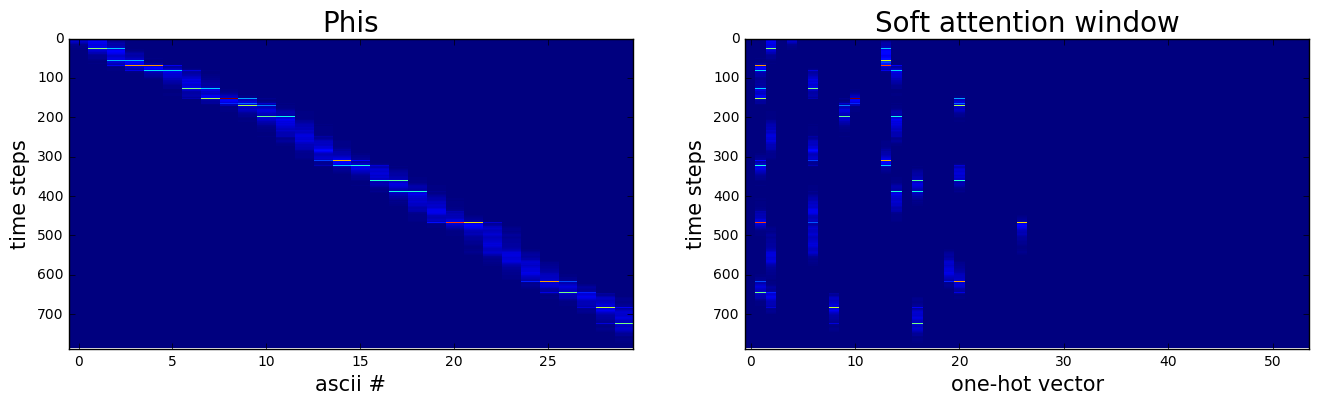

In [18]:
# plots parameters from the attention mechanism
def window_plots(phis, windows):
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.title('Phis', fontsize=20)
    plt.xlabel("ascii #", fontsize=15)
    plt.ylabel("time steps", fontsize=15)
    plt.imshow(phis, interpolation='nearest', aspect='auto', cmap=cm.jet)
    plt.subplot(122)
    plt.title('Soft attention window', fontsize=20)
    plt.xlabel("one-hot vector", fontsize=15)
    plt.ylabel("time steps", fontsize=15)
    plt.imshow(windows, interpolation='nearest', aspect='auto', cmap=cm.jet)
    
window_plots(phis, windows)

### Mixture Density Network $\pi$ probabilities:
Each element of the `pis` vector corresponds to the probability that the model will sample a point from that Gaussian component. Notice that the model has learned to draw from different distributions depending on what letters/strokes it is drawing

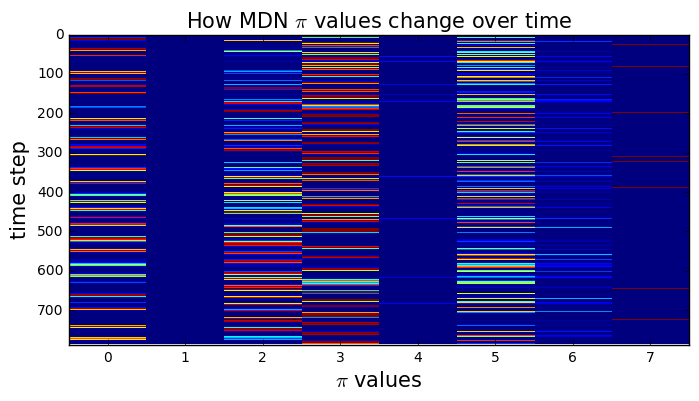

In [19]:
plt.figure(figsize=(8,4))
plt.title("How MDN $\pi$ values change over time", fontsize=15)
plt.xlabel("$\pi$ values", fontsize=15)
plt.ylabel("time step", fontsize=15)
plt.imshow(pis, interpolation='nearest', aspect='auto', cmap=cm.jet)

### Stroke probability
The model as learned to predict diffuse distributions at the beginning of pen strokes and peaky distributions in the middle (where uncertainty in the next point's location is much lower)

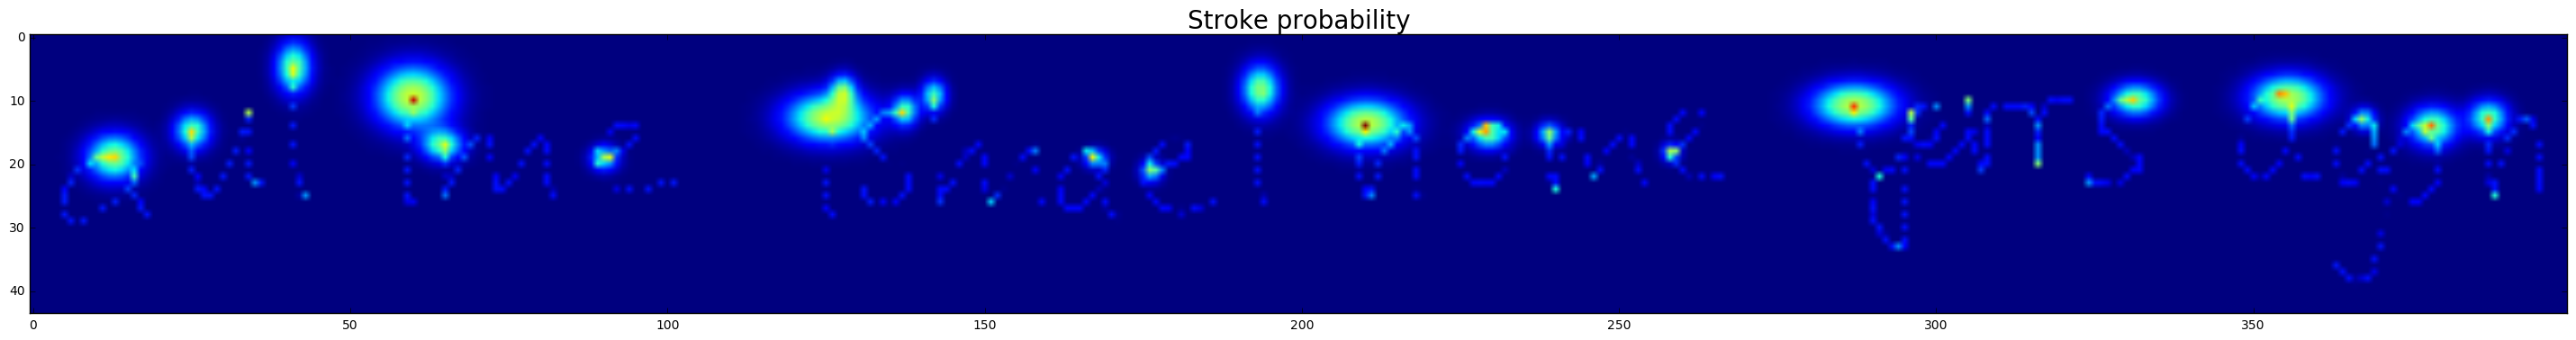

In [20]:
def gauss_plot(strokes, title, figsize = (20,2)):
    plt.figure(figsize=figsize)
    import matplotlib.mlab as mlab
    buff = 1 ; epsilon = 1e-4
    minx, maxx = np.min(strokes[:,0])-buff, np.max(strokes[:,0])+buff
    miny, maxy = np.min(strokes[:,1])-buff, np.max(strokes[:,1])+buff
    delta = abs(maxx-minx)/400. ;

    x = np.arange(minx, maxx, delta)
    y = np.arange(miny, maxy, delta)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    for i in range(strokes.shape[0]):
        gauss = mlab.bivariate_normal(X, Y, mux=strokes[i,0], muy=strokes[i,1], \
            sigmax=strokes[i,2], sigmay=strokes[i,3], sigmaxy=0) # sigmaxy=strokes[i,4] gives error
        Z += gauss * np.power(strokes[i,3] + strokes[i,2], .4) / (np.max(gauss) + epsilon)

    plt.title(title, fontsize=20)
    plt.imshow(Z)
    
gauss_plot(strokes, "Stroke probability", figsize = (2*model.ascii_steps,4))

### Line plot:
Last but not least, let's generate some handwriting. Since the LSTMs' states start out as zeros, the model generally chooses a random style and then maintains that style for the rest of the sample. If you repeat the sampling a couple times, you'll see everything from messy, scrawling cursive to neat print. Each 'style' comes from one of the writers of the dataset.

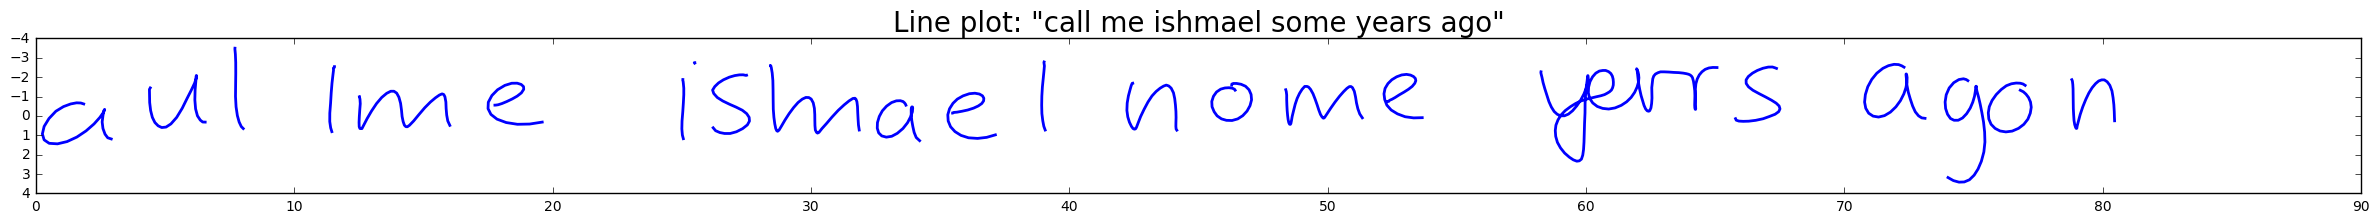

In [21]:
# plots the stroke data (handwriting!)
def line_plot(strokes, title, figsize = (20,2)):
    plt.figure(figsize=figsize)
    eos_preds = np.where(strokes[:,-1] == 1)
    eos_preds = [0] + list(eos_preds[0]) + [-1] #add start and end indices
    for i in range(len(eos_preds)-1):
        start = eos_preds[i]+1
        stop = eos_preds[i+1]
        plt.plot(strokes[start:stop,0], strokes[start:stop,1],'b-', linewidth=2.0) #draw a stroke
    plt.title(title,  fontsize=20)
    plt.gca().invert_yaxis()
    plt.show()
    
line_plot(strokes, 'Line plot: "{}"'.format(args.text), figsize=(model.ascii_steps,2))